In [2]:
%matplotlib inline
from datascience import *
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

# Predicting Dew Point Temperature From Temp. and Humidity Readings 

Magnus Equation $$P(T_c) = 0.61094 \ exp\left(\dfrac{17.625T_c}{T_c + 243.04}\right) \quad [hpa].$$

Manipulating the equation algebraically, the equation can be solved for Temperature instead. Thus, the Inverse Magnus Equation is described as $$ T_c(P) = 243.04 \dfrac{ ln\left(\dfrac{0.61094}{P}\right)} {ln\left(\dfrac{P}{0.61094}\right)- 17.625} \quad [C^o].$$

In relation to the numerical approximation to water vapor pressure, relative humidty is calculated as well $$H_r = \dfrac{P_{partial}}{P_{absolute}}.$$

Since the standard dry bulb temperature and humidity are being sampled, the relative humidity ratio can be algebrically manipulated. Thus, the equation for this applicatin will be used $$P_{partial} = \dfrac{H_r}{P_{absolute}} \quad [mmHG].$$

The circut design can be found here.

In [8]:
def magnus_eq(temperature):
    """This function takes in temperature in Celsius and 
       returns the absolute pressure in hpa."""
    
    pressure = 0.61094 * np.exp( (17.625 * temperature) / 
                                 (temperature + 243.04) )
    return pressure

def inverse_magnus_eq(pressure): 
    """This function takes in pressure and returns the corresponding temperature in Celsius."""
    dew_temp = 243.04 * ((np.log(0.61094 / pressure)) / (
                              np.log(pressure / 0.61094) - 17.625))
    return dew_temp

def compute_part_pressure(humidity, abs_pressure, perc=True):
        """This function takes in humidity and absolute pressure and
            returns the partial pressure values in hpa."""
        torr_pressure = get_torr_val(abs_pressure)
        if perc is True:
            p_pressure = (humidity / 100) * torr_pressure
        elif perc is False:
            p_pressure =  humidity * torr_pressure        
        return get_hpa_val(p_pressure)

def dewpoint_temperature(temp_celcius, humidity):
    """This function takes in temperature in Celsius and humidity in percent
        and returns the dew point temperature."""
    # check if temp is in celcius
    total_pressure = magnus_eq(temp_celcius)
    partial_pressure = compute_part_pressure(humidity, total_pressure)
    dew_temp = inverse_magnus_eq(partial_pressure)
    return dew_temp

def compute_tbl_dewtemp(tbl, label_tempC, label_humidity):
    """This function takes in a table, label containing the temperature column, 
        and label containing the humidity column and 
        returns an array containing the dewp point temperature values in Celsius."""
    dewpoint_tempC = list(map(dewpoint_temperature, tbl.column(label_tempC), tbl.column(label_humidity)))
    return np.array(dewpoint_tempC)


# conversion functions
def get_celsius(temp_farh):
    """Converts Farenheit to Celsius."""
    return (temp_farh - 32) * 5 / 9
def get_fahrenheit(temp_celsius):
    """Converts Celsius to Farenheit."""
    return temp_celsius * 9 / 5 + 32

def get_torr_val(hpa_value):
    """Converts hpa to torr."""
    return hpa_value * 1.33322
def get_hpa_val(torr_value):
    """Converts torr to hpa."""
    return torr_value * 0.7501

# selectors
def get_column(label, tbl):
    return tbl.column(label)

# Accuracy of Magnus Equation
>## Test Example: Weatherbug.com

The data below was sampled from the local weather from weatherbug.com. The data consists of the hourly time, predicted temperature, humidity, and dew point temperature.

The data from Weatherbug was sampled from Jan 10, 10:00 2021, to Jan 11, 09:00 2021.

In [9]:
hour_time = np.append(np.arange(10, 24), np.arange(0, 10)) #[10, 9, 23]: 10am - 9am
time_tracker = np.arange(len(hour_time))
temp_in_farh = make_array(41, 45, 48, 50, 54, 55, 55, 52, 50, 46, 46, 45,
                          43, 43, 41, 41, 39, 39, 39, 39, 39, 37, 37, 39)
humidity_perc = make_array(92, 82, 75, 67, 60, 56, 57, 64, 73, 77, 82, 85,
                           87, 88, 92, 93, 94, 93, 93, 93, 92, 94, 95, 94)
obs_dew_temp = make_array(39, 41, 41, 39, 39, 39, 39, 41, 41, 41, 41, 41,
                          39, 39, 39, 37, 37, 37, 37, 37, 37, 36, 36, 37)

weatherbug_data = Table().with_columns("Time(Hr)", hour_time, "time count", time_tracker,
                                       "Temp(F)", temp_in_farh, "Humidity(%)", humidity_perc, 
                                       "Weatherbug Dew Point(F)", obs_dew_temp)

Time(Hr),time count,Temp(F),Humidity(%),Weatherbug Dew Point(F)
10,0,41,92,39
11,1,45,82,41
12,2,48,75,41
13,3,50,67,39
14,4,54,60,39


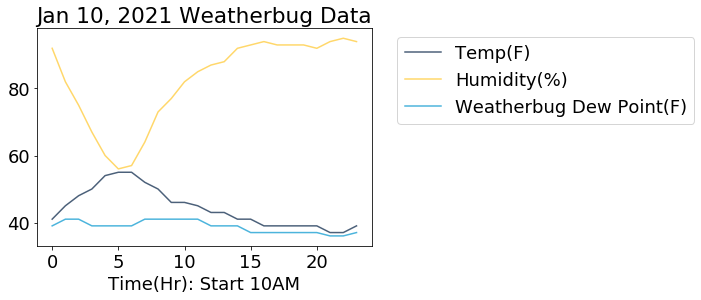

In [10]:
wb_hour_time = get_column("Time(Hr)", weatherbug_data)
wb_hour_count = get_column("time count", weatherbug_data)
wb_tempF = get_column("Temp(F)", weatherbug_data)
wb_humidity = get_column("Humidity(%)", weatherbug_data)
wb_dewtempF = get_column("Weatherbug Dew Point(F)", weatherbug_data)

weatherbug_data.show(5)
weatherbug_data.plot(1, [2, 3, 4])
plt.title("Jan 10, 2021 Weatherbug Data")
plt.xlabel("Time(Hr): Start 10AM");

In [11]:
weatherbug_tempC = get_celsius(weatherbug_data.column("Temp(F)"))
weatherbug_data = weatherbug_data.with_column("Temp(C)", weatherbug_tempC)
weatherbug_dewtempsC = compute_tbl_dewtemp(weatherbug_data, "Temp(C)", "Humidity(%)") # need to fixed
weatherbug_dewtempsF = get_fahrenheit(weatherbug_dewtempsC)
weatherbug_dewpt_tbl = weatherbug_data.with_columns("Emperical Dew Point(C)", np.round(weatherbug_dewtempsC, 2),
                                                    "Emperical Dew Point(F)", np.round(weatherbug_dewtempsF, 2))
weatherbug_dewpt_tbl.show(10)

Time(Hr),time count,Temp(F),Humidity(%),Weatherbug Dew Point(F),Temp(C),Emperical Dew Point(C),Emperical Dew Point(F)
10,0,41,92,39,5,3.81,38.86
11,1,45,82,41,7.22222,4.35,39.84
12,2,48,75,41,8.88889,4.7,40.46
13,3,50,67,39,10,4.15,39.48
14,4,54,60,39,12.2222,4.68,40.43
15,5,55,56,39,12.7778,4.22,39.59
16,6,55,57,39,12.7778,4.47,40.05
17,7,52,64,41,11.1111,4.56,40.2
18,8,50,73,41,10,5.38,41.69
19,9,46,77,41,7.77778,4,39.2


When observing the results, temperature and humidity have a strong relationship. However, the dewpoint temperature is relatively constant compared to temperature, humidity. 

This observation is consistent with the characteristic of the Magnus Equation which is that Water Vapor Pressure is not heavily dependent on Temperature. 

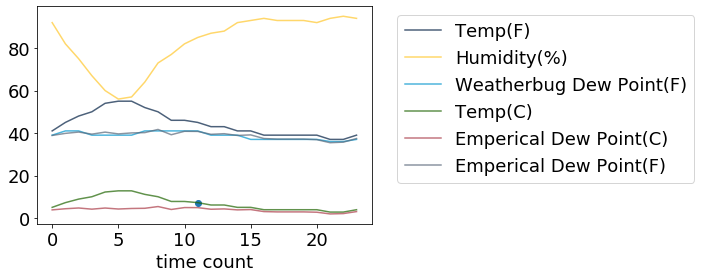

In [12]:
weatherbug_dewpt_tbl.plot(1, [2, 3, 4, 5, 6, 7])
current_time = weatherbug_dewpt_tbl.where("Time(Hr)", are.equal_to(21))
plt.scatter(current_time.column(1), current_time.column(5));

When observing the Dew Point Temperatures sampled by Weatherbug and produced by the Magnus Equation versus the 24 hour time interval, the trend of each respective value is mostly asymptotic. Thus, implying that the equation used to predict the sample readings provided by Weatherbug is consistent.

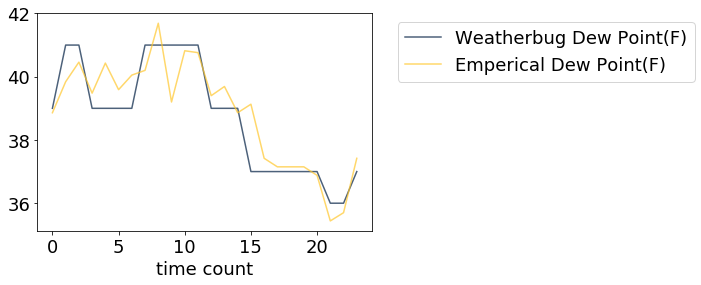

In [13]:
weatherbug_dewpt_tbl.plot(1, [4, 7])
# plt.scatter(current_time.column(2), current_time.column(5));

# Error Analysis 
## Checking the Accuracy of the Magnus Equation 

To see how accurate the Magnus and Inverse Magnus Equations are. The formulas will be treated as a regression equation. Therefore, the root mean square error (RMSE) can be applied to find the accuracy of the original equation.

Sequentially, the following code will simulate the results from the regression equation and compute the root mean square error 50,000 times. Thus, the law of large numbers will apply to the RMSE.

In [14]:
def rmse(y, y_hat):
    """Computes the root mean squared differences between y and y_hat"""
    return np.sqrt(np.mean( (y - y_hat)**2 ))


In [15]:
temp_simulation_results = make_array()
simulations = np.arange(50000)
simulation_temp_tbl = weatherbug_dewpt_tbl.select("Temp(C)", "Humidity(%)")

for simulation in simulations:
    temp_bootstrap = simulation_temp_tbl.sample()
    current_pressure = magnus_eq(temp_bootstrap.column("Temp(C)"))
    sim_temperature = inverse_magnus_eq(current_pressure)
    temp_error = rmse(simulation_temp_tbl.column("Temp(C)") ,sim_temperature)
    temp_simulation_results = np.append(temp_simulation_results, temp_error)

Mean RMSE: 4.44


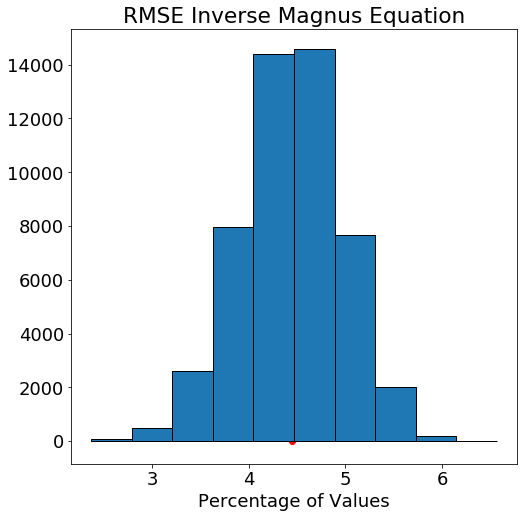

In [16]:
sim_inv_mag_mean = np.mean(temp_simulation_results)
print("Mean RMSE:", np.round(sim_inv_mag_mean, 2))
plt.hist(temp_simulation_results)
plt.scatter(sim_inv_mag_mean, -0.1, color='red')
plt.title("RMSE Inverse Magnus Equation")
plt.xlabel("RMSE")
plt.xlabel("Percentage of Values");

In [19]:
simulations, rmse_results = np.arange(50000), make_array()
simulation_tbl = weatherbug_dewpt_tbl.select("Temp(C)", "Humidity(%)", "Weatherbug Dew Point(F)")

for simulation in simulations:
    bootstrap_tbl = simulation_tbl.sample()
    sim_emperical_dewtempC = compute_tbl_dewtemp(bootstrap_tbl, "Temp(C)", "Humidity(%)")
    sim_emperical_dewtempF = get_fahrenheit(sim_emperical_dewtempC)
    error = rmse(bootstrap_tbl.column("Weatherbug Dew Point(F)"), sim_emperical_dewtempF)
    rmse_results = np.append(rmse_results, error)

Mean RMSE: 0.8


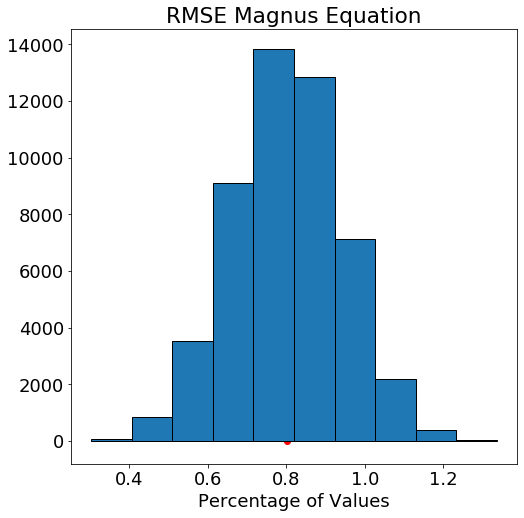

In [20]:
mag_sim_mean_error = np.mean(rmse_results)
print("Mean RMSE:", np.round(mag_sim_mean_error, 2))
plt.hist(rmse_results)
plt.scatter(mag_sim_mean_error, -8, color='red')
plt.title("RMSE Magnus Equation")
plt.xlabel("RMSE")
plt.xlabel("Percentage of Values");

As a result, the average RMSE is approximately 0.8. This result implies that the Magnus Equation provides an accurate representation of predicting the Dew Point Temperature relative to the results provided by WeatherBug. The average RMSE for the Inverse Magnus Equation is approximately 4.4 this implies that while the error is still low, inverting the Magnus equation to find temperature based on pressure is less accurate. 

# Accuracy Results
Since the equations used to predict the dew point temperature show promise from the results of the RMSE, they will be used to predict the local dew point temperature from the temperature and humidity readings sampled by the temperature sensor.

# Realtime Sampling of Temperature and Humidity. 
Data was captured with the HT11 temperature and Humidity Sensor. Information on the circuit design can be found [here](https://tutorials-raspberrypi.com/raspberry-pi-measure-humidity-temperature-dht11-dht22/).


In [21]:
# # need to generalize the table filtering process to reduce the amount of code generated
# def split_columns(tbl):
#     """This function takes in a table and extracts all values and returns a nested list containing values by column"""
#     tbl_values, labels = [], tbl.labels
#     for label in labels:
#         tbl_values.append(tbl.column(label))
#     return tbl_values

# def filter_numerical_entries(unfilter_tbl, labels):
#     # convert numberical data from string to floats
#     table = unfilter_tbl    
#     for label in labels:
#         temp = unfilter_tbl.apply(float, label)
#         table = unfilter_tbl.with_column(label, temp) 
#     return table

# def update_columns(table, column_lst, labels):
#     column_num = 0
#     for label in labels:
#         table = table.with_column(label, column_lst[column_num])
#         column_num += 1
#     return table

# def plot_values(vector_a, vector_b, color='blue'):
#     return plt.plot(vector_a, vector_b, color)
# def scatter_values(vector_a, vector_b, color='blue'):
#     return plt.scatter(vector_a, vector_b, color)

In [22]:
temp_humid_sample1 = 'TempHumid_data_ONLY(first sample).csv'
temp_humid_sample2 = 'TempHumSon_data(second sample).csv'
weather_sample1 = Table.read_table(temp_humid_sample1).drop(3, 4, 5, 6)
weather_sample2 = Table.read_table(temp_humid_sample2).drop(3, 4, 5, 6)
weather_data = weather_sample1.append(weather_sample2)
weather_data.show(5)

Date,Hour,Time(MS),Temperature(C),Temperature(F),Humidity(%)
Tue Jan 12 11:42:40 2021,11,3454192,20,68,47
Tue Jan 12 11:42:40 2021,11,3459259,20,68,47
Tue Jan 12 11:42:41 2021,11,3464327,20,68,47
Tue Jan 12 11:42:41 2021,11,3469396,20,68,47
Tue Jan 12 11:42:42 2021,11,3477126,20,68,47


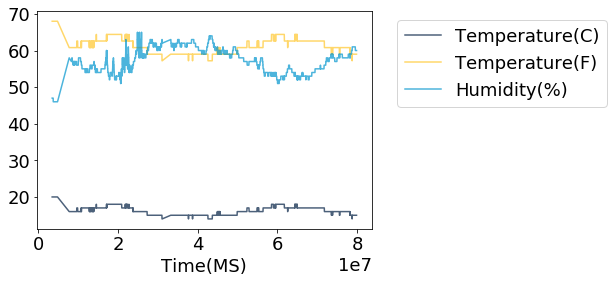

In [23]:
weather_data.plot("Time(MS)", ["Temperature(C)", "Temperature(F)", "Humidity(%)"])

# Exploratory Analysis

Upon observing the scatterplot versus the time measurement, there are a few ambiguous readings. Therefore, to confirm if the sensor or program had trouble appending the data, observing a neighborhood of samples will determine if this is the case.

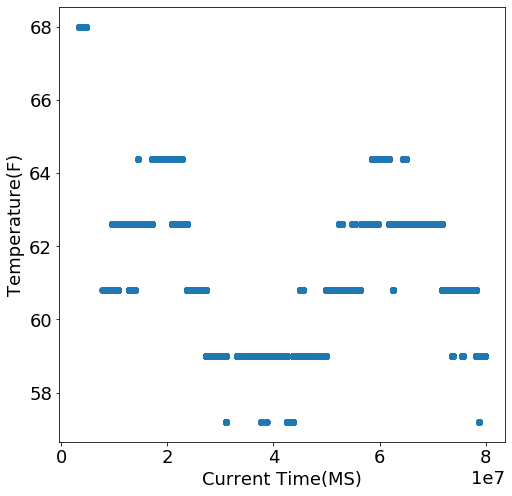

In [24]:
plt.scatter(weather_data.column("Time(MS)"), weather_data.column('Temperature(F)'));
plt.xlabel("Current Time(MS)")
plt.ylabel("Temperature(F)");

To confirm the temperature readings are in chronological order with respect to time, a neighborhood of points to confirm this is the case, and the temperature readings are not undefined.

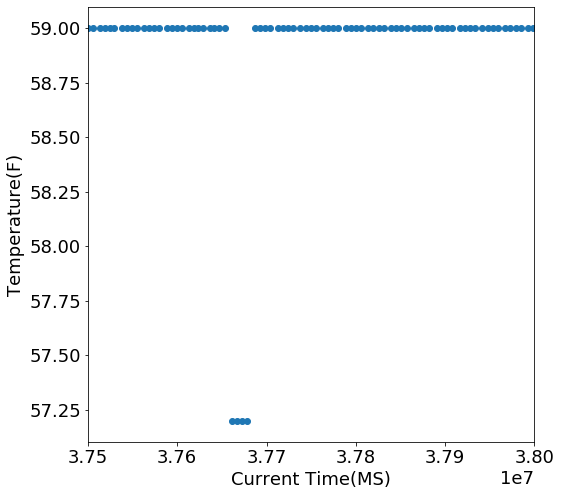

In [25]:
neighbor_temps = weather_data.where("Time(MS)", are.between(3e+7, 4e+7))
plt.scatter(neighbor_temps.column("Time(MS)"), neighbor_temps.column("Temperature(F)"))
plt.xlim([3.75e+7, 3.8e+7]) # local neighborhood bounds
plt.xlabel("Current Time(MS)")
plt.ylabel("Temperature(F)");

Now can observe temperature and humidity versus time. From the inital observation, the inverse relationship between temperature and humidity with respect to time can be seen. The sample results show promise such that it is consistant with the results from the data from Weatherbug.com.

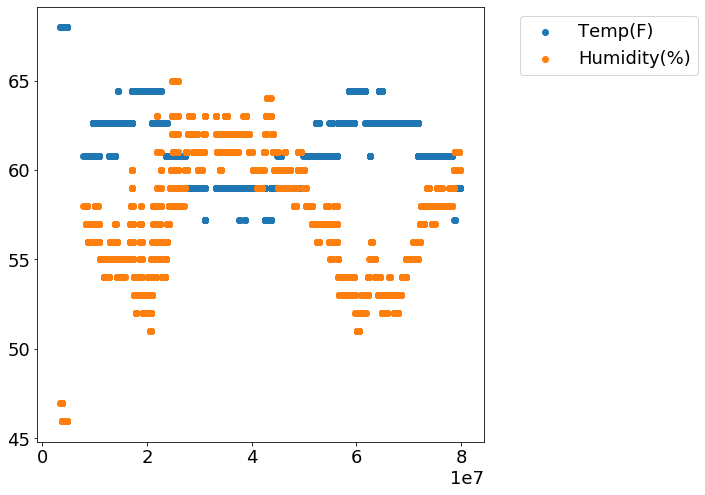

In [26]:
plt.scatter(weather_data.column("Time(MS)"), weather_data.column('Temperature(F)'), label="Temp(F)")
plt.scatter(weather_data.column("Time(MS)"), weather_data.column('Humidity(%)'), label="Humidity(%)")
plt.legend(bbox_to_anchor=(1.5, 1),loc="upper right");

# Cut Velocity since cannot find referecne

When observing the relationship of temperature and the speed of sound, the trend appears to be linear! This the case since the speed of sound can be expressed as a function of humidity and temperature in Celsius. $$V_{sound} = 331.3[m/s] + (0.606 * Temp_C) + (0.0124 * Humidity_{percent})$$

In [27]:
# plt.plot(weather_data.column("Time(MS)"), weather_data.column("Sound Velocity(cm/s)"))
# # plt.xlabel("Time(MS)")
# plt.ylabel("Velocity(cm/s)");

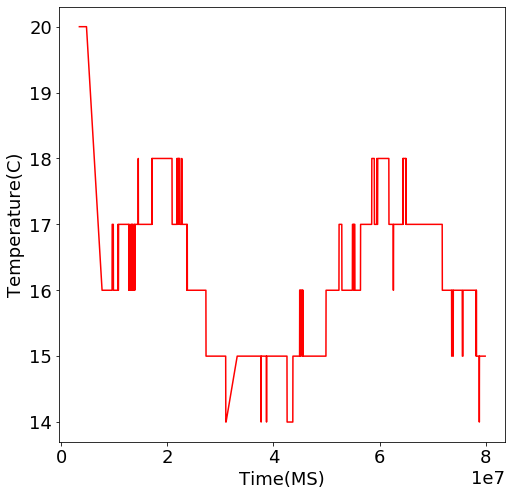

In [28]:
plt.plot(weather_data.column("Time(MS)"), weather_data.column("Temperature(C)"), color='red')
plt.xlabel("Time(MS)")
plt.ylabel("Temperature(C)");

After exploring the sample observations, partial pressure and dewpoint temperatures can be observed. 

In [31]:
abs_pressure = magnus_eq(weather_data.column("Temperature(C)"))
data_partial_pressure = compute_part_pressure(weather_data.column("Humidity(%)"), abs_pressure) #hpa
dewtempC = compute_tbl_dewtemp(weather_data, "Temperature(C)", "Humidity(%)")
dewtempF = get_fahrenheit(dewtempC)

dew_weather = weather_data.with_columns("Absolute Pressure(hpa)", abs_pressure, "Partial Pressure(hpa)", data_partial_pressure,
    "Dew Temp(C)", dewtempC, "Dew Temp(F)", dewtempF)#.drop(3, 5, 6)

Date,Hour,Time(MS),Temperature(C),Temperature(F),Humidity(%),Absolute Pressure(hpa),Partial Pressure(hpa),Dew Temp(C),Dew Temp(F)
Tue Jan 12 11:42:40 2021,11,3454192,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 11:42:40 2021,11,3459259,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 11:42:41 2021,11,3464327,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 11:42:41 2021,11,3469396,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 11:42:42 2021,11,3477126,20,68,47,2.33344,1.09677,8.34566,47.0222


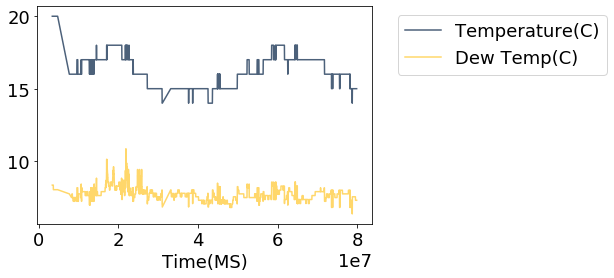

In [32]:
dew_weather.show(5)
dew_weather.plot("Time(MS)", ["Temperature(C)","Dew Temp(C)"])

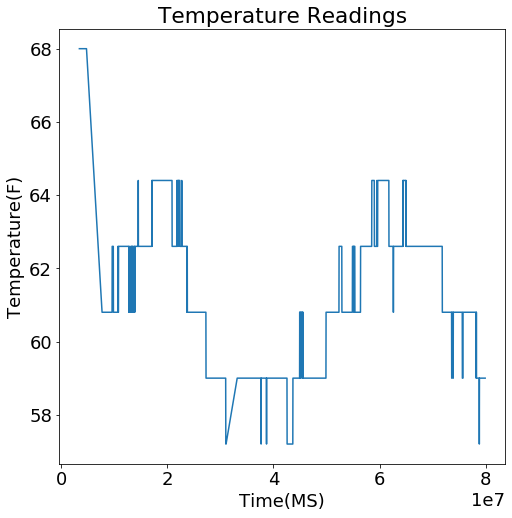

In [33]:
plt.plot(dew_weather.column("Time(MS)"), dew_weather.column('Temperature(F)'))
plt.title("Temperature Readings")
plt.xlabel("Time(MS)")
plt.ylabel("Temperature(F)");

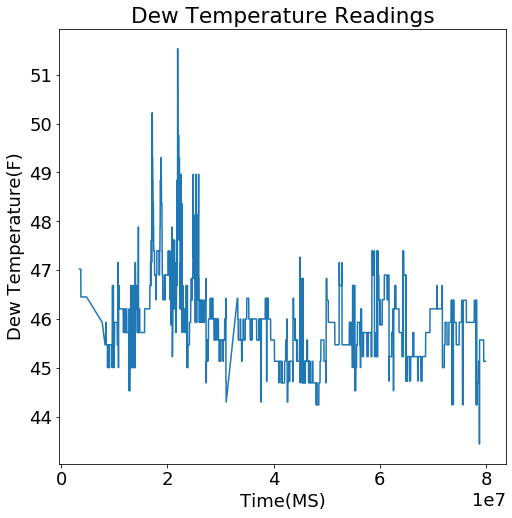

In [34]:
plt.plot(dew_weather.column("Time(MS)"), dew_weather.column("Dew Temp(F)"));
plt.title("Dew Temperature Readings")
plt.xlabel("Time(MS)")
plt.ylabel("Dew Temperature(F)");

# Smoothing Operator: Moving Average
The data observed contains noise that makes the information of interest difficult to find. Therefore, a method that can smooth the oscillations from the sample data is using an average. Since the sampling frequency is 2 samples per second, a 600 point moving average is applied to the temperature data to smooth the trend line which displays the change in dewpoint temperature every 5 minutes.

In [35]:
def moving_average(domain_arr, range_arr, points=4):
    """This function takes in the output array and the corresponding domain array and returns a list containing the 
        kth point average and the inital domain value of the subinterval."""
    smooth_domain, smooth_range = make_array(), make_array()
    for point in range(0, np.prod(range_arr.shape), points):
        kth_points = range_arr[point:point+4]
        smooth_domain = np.append(smooth_domain, domain_arr[point:])
        smooth_range = np.append(smooth_range, np.mean(kth_points))
    return [smooth_domain, smooth_range]

def tbl_moving_average(tbl, domain_label, points):
    """This function takes in a table, a list containing the domain columns and  
        number of requered smaple points and returns a table 
        that represents the moving average of the input table."""
    temp_tbl = tbl.drop(domain_label)
    column_labels = list(temp_tbl.labels)
    moving_point_tbl = Table()
    moving_point_vals, smooth_domain = make_array(), make_array()
    while domain_label:
        for point in range(0, tbl.num_rows, points):
            smooth_domain = np.append(smooth_domain, tbl.column(domain_label[0])[point:point+4])
        moving_point_tbl = moving_point_tbl.with_column(domain_label[0], smooth_domain)
        domain_label.pop(0)
        smooth_domain = make_array()

    while column_labels:
        for point in range(0, tbl.num_rows, points):
            kth_points = tbl.column(column_labels[0])[point: point+4]
            moving_point_vals = np.append(moving_point_vals, kth_points)
        
        moving_point_tbl = moving_point_tbl.with_column(column_labels[0], moving_point_vals)
        column_labels.pop(0)
        moving_point_vals = make_array()
    return moving_point_tbl

# selectors
def move_avg_domain(lst):
    return lst[0]
def move_avg_range(lst):
    return lst[1]

In [36]:
five_min_sample = 600 // 2 #5 min subinterval: (2 * (60 * 10) // 2)
dew_moveavg = tbl_moving_average(dew_weather, ['Date','Hour','Time(MS)'], five_min_sample)
dew_moveavg.show(5)

Date,Hour,Time(MS),Temperature(C),Temperature(F),Humidity(%),Absolute Pressure(hpa),Partial Pressure(hpa),Dew Temp(C),Dew Temp(F)
Tue Jan 12 11:42:40 2021,11,3.45419e+06,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 11:42:40 2021,11,3.45926e+06,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 11:42:41 2021,11,3.46433e+06,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 11:42:41 2021,11,3.4694e+06,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 12:02:09 2021,12,8.65563e+06,16,60.8,57,1.81462,1.03439,7.48467,45.4724


Observing the two tables pre and post moving average, trends become more apparent in the moving average table. 

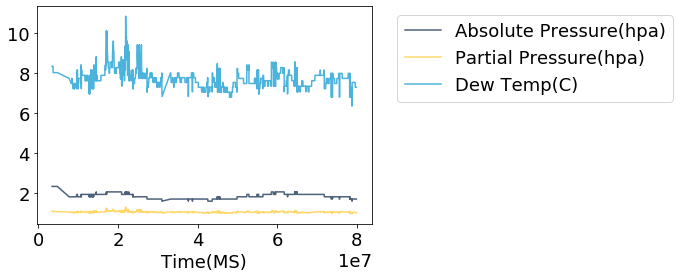

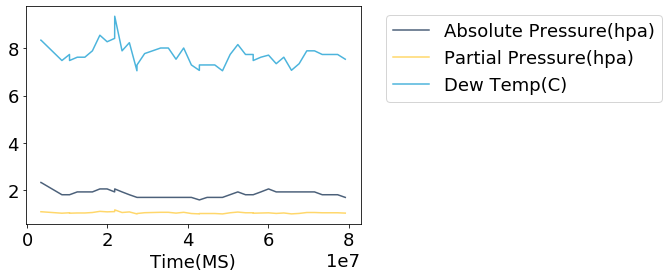

In [37]:
dew_weather.plot(2, ['Absolute Pressure(hpa)', 'Partial Pressure(hpa)', 'Dew Temp(C)'])
dew_moveavg.plot(2, ['Absolute Pressure(hpa)', 'Partial Pressure(hpa)', 'Dew Temp(C)'])

Specifying the dewpoint temperature, when observing the trendline constructed from the moving average, the dew trend of point temperature readings within the sample can be seen.

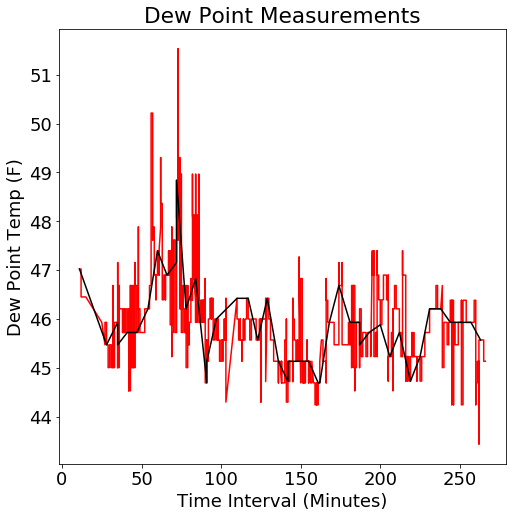

In [38]:
plt.plot(dew_weather.column("Time(MS)") // 300000, dew_weather.column("Dew Temp(F)"), color='red')
plt.plot(dew_moveavg.column("Time(MS)") // 300000, dew_moveavg.column("Dew Temp(F)"), color='black')
plt.title("Dew Point Measurements")
plt.xlabel("Time Interval (Minutes)")
plt.ylabel("Dew Point Temp (F)");

# Fourier Series 

The Fourier Series can be represented in two forms: the special case where the interval for all Fourier representations of a function will be within the interval $$-\pi < var < \pi .$$ And the general case where a Fourier Series can represent any function or data vectors over any symmetric interval $$-L < var < L .$$ 

For the special case, the corresponding Fourier Series can be represented as $$FST(x) = a_0 + \sum_{n=1}^{\infty} a_ncos(nx) + \sum_{n=1}^{\infty} b_nsin(nx)$$ for interval $-\pi < x < \pi .$

For the general case, the corresponding Fourier Series can be represented as $$ FST(t) = \dfrac{a_0}{2} + \sum_{n=1}^{\infty} a_ncos(\dfrac{2\pi nt}{L}) + \sum_{n=1}^{\infty} b_nsin(\dfrac{2\pi nt}{L}) $$ for interval $-L < x < L .$ 

## Implementation of Fourier Series: Spectral Analysis

It is important to note that the implementation of the Fourier Series above as the Fourier Transform algorithm that implements this process is known as the "Naive Fourier Transform"(NFT). The reason for this that the computational time for the NFT is $O(N^2)$. This means that without the moving average, the table has approximately 11k rows and therefore the NFT will be extremely impractical. 

In any case, the NumPy package will be imported to use the "Fast Fourier Transform" with a computational time of $O(nlog(n))$. 
Futher documentation can be found [here](https://appdividend.com/2020/04/29/numpy-fft-how-to-apply-fourier-transform-in-python/).

The Fourier transform of the temperature describes the sinusoidal waves that constructing the Dew Point temperature waveform. The complex values $z = a_{re} + b_{im}i$ in the context of the Fourier coefficients the magnitude describes the amplitude of the sinusoidal waveforms, and the phase corresponds to the initial angle of the corresponding sinusoidal waveform. Phase can be found by the Pythagorean Theorem. 

Specifically: 
$$Amplitude = \sqrt{a_{re}^2 + b_{im}^2}$$
$$Phase = arctan\left( \frac{b_{im}}{a_{re}} \right)$$ 

Using the expected average, the average density displays the sinusoidal waves that have the most impact on the construction of the Dew Point temperature waveform. 

### Note:
>Unfortunately, understanding the implications of the frequency domain on this system is out of my scope of knowledge at this time. This section will be updated as I gain more experience in this subject. 
However, the only correlation that I can theorize from my findings of Spectral Density is that since the frequency domain describes the correct amplitude at which sinusoidal waves construct the temperature waveform, the higher frequencies are the biggest contribution to the composition of the temperature waveform. This implies that I can somewhat interpret the frequency domain of a system as a histogram. Since histograms describe how much of an object/value occurs, the more dense a bin a histogram is, the more that bin has a contribution to the observed system. Thus, the translation of understanding the frequency domain may possibly be similar in nature such that the higher the frequency(assuming noise has been minimized), the bigger contribution a sinusoidal waveform must have at that amplitude within the temperature waveform. Similar to the law of large numbers and the average value is most likely to be found in the more dense areas of a histogram. 

In [39]:
frequency_domain = np.fft.fftfreq(dew_moveavg.column("Time(MS)").shape[0])
fft_dewtemp = np.fft.fft(dew_moveavg.column("Dew Temp(C)"))
fft_dewtemp[0] = 0 # remove Signal produced by the DC Voltage

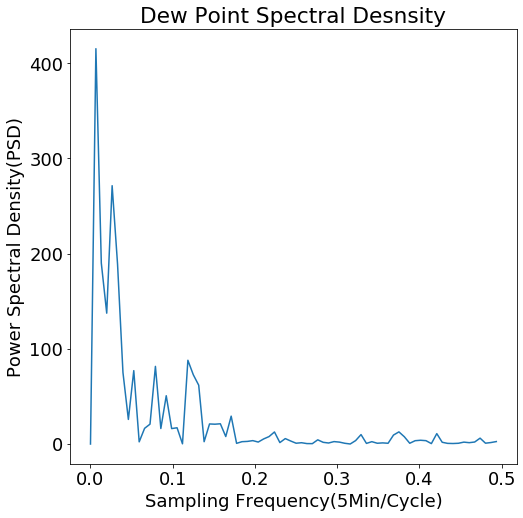

In [61]:
half_freq_domain = frequency_domain[0: frequency_domain.size // 2]
half_fft_vals = fft_dewtemp[:fft_dewtemp.size // 2]
modulus_fft = np.abs(half_fft_vals) # take real coefficients

plt.plot(half_freq_domain, modulus_fft ** 2)
plt.xlabel("Sampling Frequency(5Min/Cycle)")
plt.ylabel("Power Spectral Density(PSD)")
plt.title("Dew Point Spectral Desnsity");

# Newton's Method and the Symbolic Derivative

The next question that arises is when the dew point temperature begins to change as time progressed in the sample? Since the change in dewpoint temperature is increasing to decreasing is apparent due to the characteristic of the waveform displayed prior to applying the moving average, the rate or how much the dewpoint temperature is increasing or decreasing is not as describable. 

Since a function that describes the dewpoint temperature exists, the inverse Magnus equation can be computed analytically thus a numerical derivative will not be necessary to answer this question. 

After symbolically working the derivative and cross-referencing with Symbolab and WolframAlpha, the first derivative to the Inverse Magnus Equation.

>[Symbolab](https://www.symbolab.com/solver/derivative-calculator/%5Cfrac%7Bd%7D%7Bdx%7D%5Cleft(%5Cfrac%7B243.04ln%5Cleft(%5Cfrac%7B0.6109%7D%7Bx%7D%5Cright)%7D%7Bln%5Cleft(%5Cfrac%7Bx%7D%7B0.61094%7D%5Cright)%20-%2017.625%7D%5Cright): 
$$T_c'(p) = 243.04\frac{\ln \left(\dfrac{p}{0.61094}\right) + 17.625 - \ln \left(\dfrac{0.61094}{p}\right)}{p\left(\ln\left(\frac{p}{0.61094}\right)\ -\ 17.625\right)^{2}}$$

>[WolframAlpha](https://www.wolframalpha.com/input/?i=d%2Fdx+243.04+%28ln%28%280.61094++%2F+x%29%29+%2F+%28ln%28x%2F0.61094%29++-+17.625%29%29): 
$$T_c'(p) = \dfrac{-243.04 \left(\ln \left( \dfrac{1}{p} \right) +  \ln \left( p \right)\right) + 4283.58} {p \, \left( \ln \left( p \right) - 17.1322 \right)^2}$$

>WolframAlpha [Second Derivative](https://www.wolframalpha.com/input/?i=d%5E2%2Fdx%5E2+243.04+%28ln%28%280.61094++%2F+x%29%29+%2F+%28ln%28x%2F0.61094%29++-+17.625%29%29):
>$$T_c''(p) = \cfrac{ln(p) \,(243.04 ln(p) - 7961.32) + ln\left( \frac{1}{p} \right) (243.04 ln(p) - 3677.74) + 64820.2} {p^2 (ln(p) - 17.1322)^3}$$

>WolframAlpha [Third Derivative](https://www.wolframalpha.com/input/?i=d%5E3%2Fdx%5E3+243.04+%28ln%28%280.61094++%2F+x%29%29+%2F+%28ln%28x%2F0.61094%29++-+17.625%29%29):
$$T_c'''(p) = \cfrac{\left( ln\left(\frac{1}{p}\right) ln(p) \right) \left( 15197 - 486.08 ln(p) - 119146 \right) + ln(p)^2 \left( 23764.2 - 486.08 ln(p) - 386994 \right) + 2.09996×10^6}{p^3 (log(p) - 17.1322)^4}$$

t_c / hpa -> (t_c / hpa) / hpa

In [41]:
def inv_mag_first_deriv(pressure):
    """This function takes in an array containing pressure values in hecto-pascals 
        and returns an array of temperture values in Celsius."""
    numerator = np.log(pressure / 0.61094) + 17.625 - np.log(0.61094 / pressure)
    denominator = pressure * (np.log(pressure / 0.61094) - 17.625) ** 2
    return (243.04 * numerator) / denominator

def inv_mag_second_deriv(pressure):
    """This function takes in an array containing pressure values in hecto-pascals 
        and returns an array of temperture values in Celsius."""
    term_denom = pressure**2 * (np.log(pressure) - 17.625) ** 3
    term_1 = np.log(pressure) * (243.04 * np.log(pressure) - 7961.32)
    term_2 = np.log(1 / pressure) * (243.04 * np.log(pressure) - 3677.74)
    term_3 = 64820.2
    return (term_1 + term_2 + term_3) / term_denom

def inv_mag_third_deriv(pressure):
    """This function takes in an array containing pressure values in hecto-pascals 
        and returns an array of temperture values in Celsius."""
    term_denom = pressure ** 3 * (np.log(pressure) - 17.1322) ** 4
    term_1 = (np.log(1 / pressure) * np.log(pressure)) * (
                15197 - 486.08 * np.log(pressure)) - 119146
    term_2 = (np.log(pressure) * np.log(pressure)) * (23764.2 - 486.08 * np.log(pressure) - 386994)
    term_3 = 2.09996e+6
    return (term_1 + term_2 + term_3) / term_denom

In [42]:
dew_moveavg.show(5)
dewtemp_deriv_foo = lambda x, h=0.001: (inv_mag_first_deriv(x + h) - inv_mag_first_deriv(x)) / h 
dewtemp_second_deriv_foo = lambda x, h=0.001: (inv_mag_second_deriv(x + h) - inv_mag_second_deriv(x)) / h 

inv_mag_ddx = np.array(list(map(dewtemp_deriv_foo, dew_moveavg.column("Temperature(C)"))))
inv_mag_d2dx2 = np.array(list(map(dewtemp_second_deriv_foo, dew_moveavg.column("Temperature(C)"))))
# print(np.mean(inv_mag), display(Markdown("$T_c/hpa$")))

Date,Hour,Time(MS),Temperature(C),Temperature(F),Humidity(%),Absolute Pressure(hpa),Partial Pressure(hpa),Dew Temp(C),Dew Temp(F)
Tue Jan 12 11:42:40 2021,11,3.45419e+06,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 11:42:40 2021,11,3.45926e+06,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 11:42:41 2021,11,3.46433e+06,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 11:42:41 2021,11,3.4694e+06,20,68,47,2.33344,1.09677,8.34566,47.0222
Tue Jan 12 12:02:09 2021,12,8.65563e+06,16,60.8,57,1.81462,1.03439,7.48467,45.4724


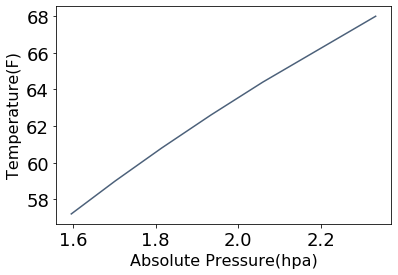

In [43]:
dew_moveavg.plot(6, [4,])

When observing the first and second derivate of the change in temperature with respect to partial pressure, it appears that during the sampling period, the dewpoint temperature is decreasing at a slower rate as the partial pressure increases. Conversely, as the partial pressure decreases, the dewpoint temperature decreases at a faster rate. When observing this observation, identifying that pressure is a proxy metric for relative humidity and, this relation is the inverse relationship of partial pressure and temperature from the Magnus Equation. Therefore, as relative humidity is higher in the air, the temperature is increasing at a slower rate when the temperature approaches the molecular phase. Conversely, as relative humidity is lower in the air, the temperature has a faster decreasing rate. However, the first and second derivative values appear to converge around the point of molecular phase for water when the temperature approaches $0^C or \, 32^F$.

In [44]:
np.mean(dew_moveavg.column("Temperature(C)")) * 9 / 5 + 32

61.309210526315795

Text(0, 0.5, 'Temperature(C)')

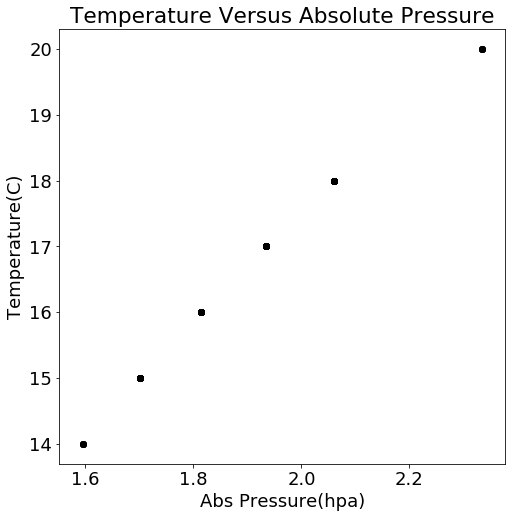

In [45]:
plt.scatter(dew_moveavg.column("Absolute Pressure(hpa)"), dew_moveavg.column("Temperature(C)"), color='black', label='Temp(C)')
plt.title("Temperature Versus Absolute Pressure")
plt.xlabel("Abs Pressure(hpa)")
plt.ylabel("Temperature(C)")

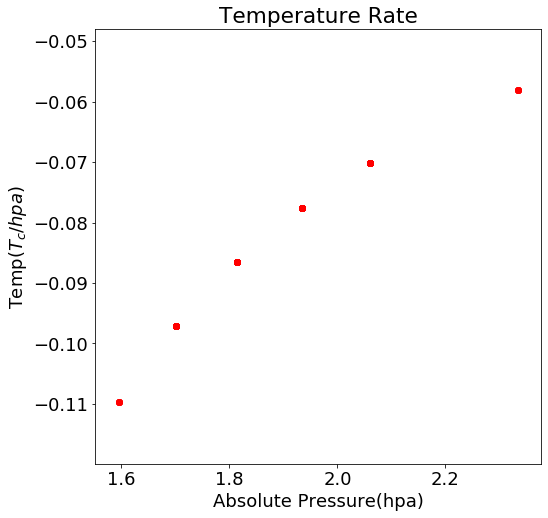

In [46]:
plt.scatter(dew_moveavg.column("Absolute Pressure(hpa)"), inv_mag_ddx, color='red', label='d/dx Temp(C)');
plt.title("Temperature Rate")
plt.xlabel("Absolute Pressure(hpa)")
plt.ylabel("Temp$(T_c / hpa)$");

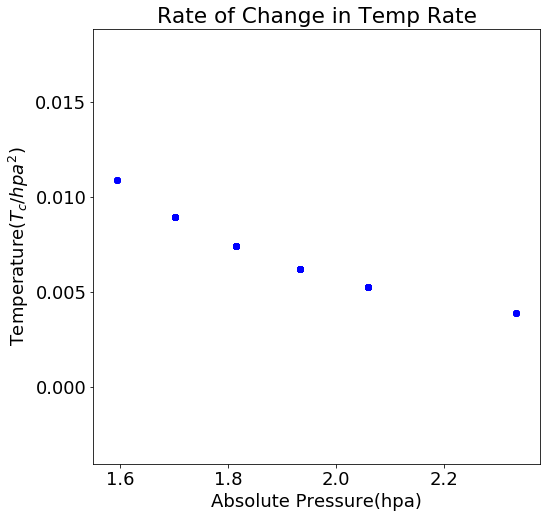

In [47]:
plt.scatter(dew_moveavg.column("Absolute Pressure(hpa)"), inv_mag_d2dx2, color='blue', label='$d^2/dx^2$ Temp(C)');
plt.title("Rate of Change in Temp Rate")
plt.xlabel("Absolute Pressure(hpa)")
plt.ylabel("Temperature$(T_c / hpa^2)$");

Is the molecular phase the convergent value? To explore this question, find the first derivative's approximated root will provide insight into this result. 

The first approach is to find potential root utilizing properties from the [Intermediate Value Theorem](https://en.wikipedia.org/wiki/Intermediate_value_theorem). Specifically, when a function's output is positive then the following output value is negative or conversely, if the initial output is negative then the following is positive, a root must exist in that interval. 

Since the units of temperature can be expressed as Fahrenheit, Celsius, or Kelvin, finding roots is quite challenging with the relative unit system. Thus, converting to standard units will transform the axis with respect to the standard deviation of the temperature values which will find the points of interest. 

In [48]:
def standardize_values(vector):
    """This Function takes in an array and returns an array of elements corresponding to 
        their standard units. z = (val - mean(val)) / SD(val)"""
    return (vector - np.mean(vector)) / np.std(vector)

def destandardize_values(su_vector, orig_vector):
    """This function takes in an array in standard units and the corresponding array in original units
        and returns an array of elements that correspond to the original units of the array 
        orig_val = SU_val * SD(val) + mean(val)."""
    
    assert np.round(np.std(su_vector)) == 1, "Array Values must be in Standard Units."
    standard_deviation = np.std(orig_vector)
    mean = np.mean(orig_vector)
    return su_vector * standard_deviation + mean

def locate_potential_zeros(domain, fn_vector):
    """This function takes in an array of input values of and array of corresponding values and 
        returns a list that contains the domain vector and range vector that satsifies 
        the conditions of the intermediate value theorem."""
    zeros, fn = [], []
    for point in np.arange(len(domain)-1):
        if fn_vector[point] < 0 and fn_vector[point + 1] > 0:
            zeros.append(domain[point])
            fn.append(fn_vector[point])
            
        elif fn_vector[point] > 0 and fn_vector[point + 1] < 0:
            zeros.append(domain[point])
            fn.append(fn_vector[point])          
    return [np.array(zeros), np.array(fn)]

# selectors
def get_domain(lst):
    return lst[0]
def get_range(lst):
    return lst[1]

In [49]:
moveavg_partial_pressure = dew_moveavg.column("Absolute Pressure(hpa)")
moveavg_dewtempC = dew_moveavg.column("Temperature(C)")

su_moveavg_partial_pressure = standardize_values(moveavg_partial_pressure)
su_moveavg_dewtempC = standardize_values(moveavg_partial_pressure)
su_temp_roots = locate_potential_zeros(su_moveavg_partial_pressure, su_moveavg_dewtempC)

After finding the potential change in temperatures in standard units, the values must be converted back into their original unit counterparts to filter the dewpoint moving average table values.

In [50]:
su_temp_tbl = Table().with_columns("Su Absolute Pressure(hpa)", 
get_domain(su_temp_roots), "Su Temperature(C)", get_range(su_temp_roots))
original_values = [dew_moveavg.column("Absolute Pressure(hpa)"),
                    dew_moveavg.column("Temperature(C)")]
original_labels = ["Absolute Pressure(hpa)", "Temperature(C)"]
convert_values = make_array()

for label in su_temp_tbl.labels:
    destandard_vals = destandardize_values(su_temp_tbl.column(label),
                                          original_values[0])
    convert_values = np.append(convert_values, destandard_vals)
#     print(convert_temp.size)
    su_temp_tbl = su_temp_tbl.with_column(original_labels[0], convert_values)
    original_values.pop(0)
    original_labels.pop(0)
    convert_values = make_array()    
    

In [53]:
su_temp_tbl.apply(get_fahrenheit, "Temperature(C)")

array([68.49448726, 60.74332797, 62.52333426, 60.74332797, 62.52333426,
       60.74332797, 62.52333426])

In [54]:
su_temp_tbl.show()

Su Absolute Pressure(hpa),Su Temperature(C),Absolute Pressure(hpa),Temperature(C)
3.31176,3.31176,2.33344,20.2747
-0.26082,-0.26082,1.81462,15.9685
0.5596,0.5596,1.93377,16.9574
-0.26082,-0.26082,1.81462,15.9685
0.5596,0.5596,1.93377,16.9574
-0.26082,-0.26082,1.81462,15.9685
0.5596,0.5596,1.93377,16.9574


In [55]:
dewtemp_potential_zeros = dew_moveavg.join("Absolute Pressure(hpa)", su_temp_tbl, "Absolute Pressure(hpa)")
dewtemp_potential_zeros.show(5)

Absolute Pressure(hpa),Date,Hour,Time(MS),Temperature(C),Temperature(F),Humidity(%),Partial Pressure(hpa),Dew Temp(C),Dew Temp(F),Su Absolute Pressure(hpa),Su Temperature(C),Temperature(C)_2
1.81462,Tue Jan 12 12:02:09 2021,12,8.65563e+06,16,60.8,57,1.03439,7.48467,45.4724,-0.26082,-0.26082,15.9685
1.81462,Tue Jan 12 12:02:09 2021,12,8.65563e+06,16,60.8,57,1.03439,7.48467,45.4724,-0.26082,-0.26082,15.9685
1.81462,Tue Jan 12 12:02:09 2021,12,8.65563e+06,16,60.8,57,1.03439,7.48467,45.4724,-0.26082,-0.26082,15.9685
1.81462,Tue Jan 12 12:02:09 2021,12,8.66393e+06,16,60.8,57,1.03439,7.48467,45.4724,-0.26082,-0.26082,15.9685
1.81462,Tue Jan 12 12:02:09 2021,12,8.66393e+06,16,60.8,57,1.03439,7.48467,45.4724,-0.26082,-0.26082,15.9685


A few observations can be made: since the relationship between partial pressure and dew temperature has potential zeros but the relationship is linear, this must imply that the values are represented as the log of the values. This makes sense since the inverse of the Magnus Equation is logarithmic.

# Using Newton's Method to Locate the Change in Temperature Within the Sample Period.

Newtons method is derived from point slope form. Thus, the precurser to the formula is as follows: $$y - y_1 = m(x - x_1)$$
since $y_1 = f(x_1)$
then:
$$y - f(x_1) = f'(x_1)(x - x_1).$$
the second point that is used in the point slope formula is the second root
when plugging in $x_2$ occurs at the root $(x_2, 0).$
Then: 
$$0 - f(x_1) = f'(x_1)(x_2 - x_1).$$
Thus, 
$$x_2 = x_1 - \dfrac{f(x_1)}{f'(x_1)}.$$
More generally:
$$x_n+1 = x_n - \dfrac{f(x_n)}{f'(x_n)}.$$
    

In [56]:
def newtons_method(potental_zero, fn, df, digit_precision=5, num_iterations=5):
    """This function takes in an intial zero, function, the dderivative of the corresponding function 
        and returns one value if num_itertions is 1 or less or a list of zeros 
        that are up to the desired precision specified by digit_precision."""
    assert digit_precision >= 0 and isinstance(digit_precision, int), "Number of significant digits must be an integer greater than zero."
    assert num_iterations >= 0 and isinstance(num_iterations, int), "Number of roots found must be an integer greater than zero."
    
    temp, roots = 0, []
    newton_zero = potental_zero - (fn(potental_zero) / df(potental_zero))
    
    while len(roots) < num_iterations and num_iterations > 1:
        root = potental_zero - (fn(potental_zero) / df(potental_zero))
        if round(root, digit_precision) == round(temp, digit_precision):
            roots.append(root)
        elif np.isinf(root) == False:
            return ["Nan Root", roots]
        else:
            potental_zero, temp = root, root
    
    if num_iterations <= 1:
        return newton_zero
    else:
        return roots

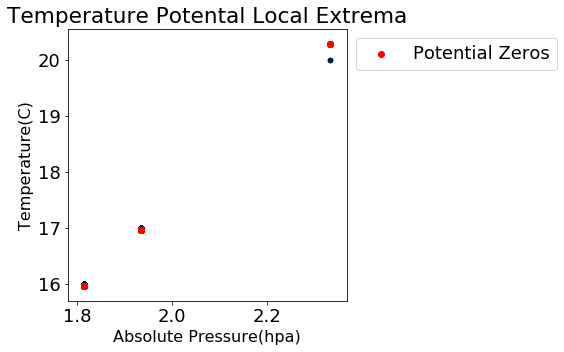

In [57]:
dewtemp_potential_zeros.scatter("Absolute Pressure(hpa)", "Temperature(C)")
plt.scatter(dewtemp_potential_zeros.column("Absolute Pressure(hpa)"),
            dewtemp_potential_zeros.column("Temperature(C)_2"), color='red', 
            label='Potential Zeros')
plt.title("Temperature Potental Local Extrema")
plt.legend(bbox_to_anchor=(1, 1));

Since there are multiple possible zeros, there are many initial zeros to start to check with Newton's Method.

In [58]:
dewtemp_first_deriv_roots, dewtemp_second_deriv_roots = make_array(), make_array()
dewtemp_initial_roots = dewtemp_potential_zeros.column("Absolute Pressure(hpa)")

for root in dewtemp_initial_roots:
    first_deriv_zero = newtons_method(root, inv_mag_first_deriv, inv_mag_second_deriv, digit_precision=0, num_iterations=1)
    second_deriv_zero = newtons_method(root, inv_mag_second_deriv, inv_mag_third_deriv, digit_precision=0, num_iterations=1)
    
    dewtemp_first_deriv_roots = np.append(dewtemp_first_deriv_roots,
                                          first_deriv_zero)
    
    dewtemp_second_deriv_roots = np.append(dewtemp_second_deriv_roots,
                                          second_deriv_zero)
    

In [59]:
dewtemp_first_deriv_roots.item(0), dewtemp_second_deriv_roots.item(0)

(4.3474960893361185, 2.741223595649228)

Unfortunately, there are no zeros found after one iteration from using newton's method. Therefore, the first root returned for the first and second derivative roots is most likely inaccurate. However, there are zeros returned. Thus, the temperature does change temperature at <firsttemp> and begins to increase/decrease at <secondddx temp>

86.81041996985826
72.72949768864513


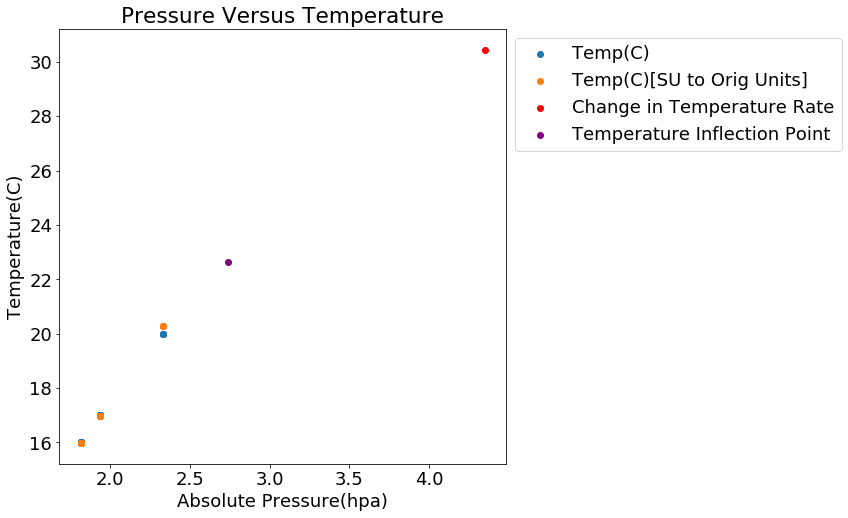

In [60]:
# use mean
print(inverse_magnus_eq(dewtemp_first_deriv_roots.item(0)) * 9 / 5 + 32) 
print(inverse_magnus_eq(dewtemp_second_deriv_roots.item(0)) * 9 / 5 + 32) 

plt.scatter(dewtemp_potential_zeros.column("Absolute Pressure(hpa)"), dewtemp_potential_zeros.column("Temperature(C)"), label='Temp(C)')
plt.scatter(dewtemp_potential_zeros.column("Absolute Pressure(hpa)"), dewtemp_potential_zeros.column("Temperature(C)_2"), label='Temp(C)[SU to Orig Units]')
plt.scatter(dewtemp_first_deriv_roots.item(0), inverse_magnus_eq(dewtemp_first_deriv_roots.item(0)), color='red', label='Change in Temperature Rate')
plt.scatter(dewtemp_second_deriv_roots.item(0), inverse_magnus_eq(dewtemp_second_deriv_roots.item(0)), color='purple', label='Temperature Inflection Point');
plt.title("Pressure Versus Temperature")
plt.xlabel("Absolute Pressure(hpa)")
plt.ylabel("Temperature(C)")
plt.legend(bbox_to_anchor=(1,1));

# Conclusion
The magnus Equation .